In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
from transformator.tree import Tree
from transformator.lambda_tree import LambdaTree
import pyAgrum.lib.notebook as gnb

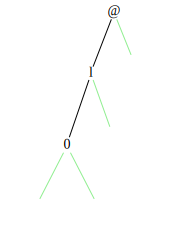

In [37]:
tree = Tree(("@", "l", "0", None, None, None, None))
tree.graph

In [38]:
trees = list(tree.visit_subtrees(lambda kind, left, right: ["l", kind] + left + right + [None]))
gnb.sideBySide(*[t._repr_svg_() for t in trees])

"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.44.1 (20200629.0846) --> <!-- Pages: 1 --> <!-- 0 --> 0 l <!-- 1 --> 1 @ <!-- 0--1 --> 0--1 <!-- 8 --> 8 <!-- 0--8 --> 0--8 <!-- 2 --> 2 l <!-- 1--2 --> 1--2 <!-- 7 --> 7 <!-- 1--7 --> 1--7 <!-- 3 --> 3 0 <!-- 2--3 --> 2--3 <!-- 6 --> 6 <!-- 2--6 --> 2--6 <!-- 4 --> 4 <!-- 3--4 --> 3--4 <!-- 5 --> 5 <!-- 3--5 --> 3--5","<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.44.1 (20200629.0846) --> <!-- Pages: 1 --> <!-- 0 --> 0 @ <!-- 1 --> 1 l <!-- 0--1 --> 0--1 <!-- 8 --> 8 <!-- 0--8 --> 0--8 <!-- 2 --> 2 l <!-- 1--2 --> 1--2 <!-- 7 --> 7 <!-- 1--7 --> 1--7 <!-- 3 --> 3 0 <!-- 2--3 --> 2--3 <!-- 6 --> 6 <!-- 2--6 --> 2--6 <!-- 4 --> 4 <!-- 3--4 --> 3--4 <!-- 5 --> 5 <!-- 3--5 --> 3--5","<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.44.1 (20200629.0846) --> <!-- Pages: 1 --> <!-- 0 --> 0 @ <!-- 1 --> 1 l <!-- 0--1 --> 0--1 <!-- 8 --> 8 <!-- 0--8 --> 0--8 <!-- 2 --> 2 l <!-- 1--2 --> 1--2 <!-- 7 --> 7 <!-- 1--7 --> 1--7 <!-- 3 --> 3 0 <!-- 2--3 --> 2--3 <!-- 6 --> 6 <!-- 2--6 --> 2--6 <!-- 4 --> 4 <!-- 3--4 --> 3--4 <!-- 5 --> 5 <!-- 3--5 --> 3--5","<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.44.1 (20200629.0846) --> <!-- Pages: 1 --> <!-- 0 --> 0 @ <!-- 1 --> 1 l <!-- 0--1 --> 0--1 <!-- 8 --> 8 <!-- 0--8 --> 0--8 <!-- 2 --> 2 0 <!-- 1--2 --> 1--2 <!-- 7 --> 7 <!-- 1--7 --> 1--7 <!-- 3 --> 3 l <!-- 2--3 --> 2--3 <!-- 6 --> 6 <!-- 2--6 --> 2--6 <!-- 4 --> 4 <!-- 3--4 --> 3--4 <!-- 5 --> 5 <!-- 3--5 --> 3--5","<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.44.1 (20200629.0846) --> <!-- Pages: 1 --> <!-- 0 --> 0 @ <!-- 1 --> 1 l <!-- 0--1 --> 0--1 <!-- 8 --> 8 <!-- 0--8 --> 0--8 <!-- 2 --> 2 0 <!-- 1--2 --> 1--2 <!-- 7 --> 7 <!-- 1--7 --> 1--7 <!-- 3 --> 3 <!-- 2--3 --> 2--3 <!-- 4 --> 4 l <!-- 2--4 --> 2--4 <!-- 5 --> 5 <!-- 4--5 --> 4--5 <!-- 6 --> 6 <!-- 4--6 --> 4--6","<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.44.1 (20200629.0846) --> <!-- Pages: 1 --> <!-- 0 --> 0 @ <!-- 1 --> 1 l <!-- 0--1 --> 0--1 <!-- 8 --> 8 <!-- 0--8 --> 0--8 <!-- 2 --> 2 0 <!-- 1--2 --> 1--2 <!-- 5 --> 5 l <!-- 1--5 --> 1--5 <!-- 3 --> 3 <!-- 2--3 --> 2--3 <!-- 4 --> 4 <!-- 2--4 --> 2--4 <!-- 6 --> 6 <!-- 5--6 --> 5--6 <!-- 7 --> 7 <!-- 5--7 --> 5--7","<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.44.1 (20200629.0846) --> <!-- Pages: 1 --> <!-- 0 --> 0 @ <!-- 1 --> 1 l <!-- 0--1 --> 0--1 <!-- 6 --> 6 l <!-- 0--6 --> 0--6 <!-- 2 --> 2 0 <!-- 1--2 --> 1--2 <!-- 5 --> 5 <!-- 1--5 --> 1--5 <!-- 3 --> 3 <!-- 2--3 --> 2--3 <!-- 4 --> 4 <!-- 2--4 --> 2--4 <!-- 7 --> 7 <!-- 6--7 --> 6--7 <!-- 8 --> 8 <!-- 6--8 --> 6--8"


In [39]:
trees = list(tree.visit_subtrees(lambda kind, left, right: ["l", kind] + left + right + [None] if kind is not None else None))
gnb.sideBySide(*[t._repr_svg_() for t in trees])

"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.44.1 (20200629.0846) --> <!-- Pages: 1 --> <!-- 0 --> 0 l <!-- 1 --> 1 @ <!-- 0--1 --> 0--1 <!-- 8 --> 8 <!-- 0--8 --> 0--8 <!-- 2 --> 2 l <!-- 1--2 --> 1--2 <!-- 7 --> 7 <!-- 1--7 --> 1--7 <!-- 3 --> 3 0 <!-- 2--3 --> 2--3 <!-- 6 --> 6 <!-- 2--6 --> 2--6 <!-- 4 --> 4 <!-- 3--4 --> 3--4 <!-- 5 --> 5 <!-- 3--5 --> 3--5","<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.44.1 (20200629.0846) --> <!-- Pages: 1 --> <!-- 0 --> 0 @ <!-- 1 --> 1 l <!-- 0--1 --> 0--1 <!-- 8 --> 8 <!-- 0--8 --> 0--8 <!-- 2 --> 2 l <!-- 1--2 --> 1--2 <!-- 7 --> 7 <!-- 1--7 --> 1--7 <!-- 3 --> 3 0 <!-- 2--3 --> 2--3 <!-- 6 --> 6 <!-- 2--6 --> 2--6 <!-- 4 --> 4 <!-- 3--4 --> 3--4 <!-- 5 --> 5 <!-- 3--5 --> 3--5","<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.44.1 (20200629.0846) --> <!-- Pages: 1 --> <!-- 0 --> 0 @ <!-- 1 --> 1 l <!-- 0--1 --> 0--1 <!-- 8 --> 8 <!-- 0--8 --> 0--8 <!-- 2 --> 2 l <!-- 1--2 --> 1--2 <!-- 7 --> 7 <!-- 1--7 --> 1--7 <!-- 3 --> 3 0 <!-- 2--3 --> 2--3 <!-- 6 --> 6 <!-- 2--6 --> 2--6 <!-- 4 --> 4 <!-- 3--4 --> 3--4 <!-- 5 --> 5 <!-- 3--5 --> 3--5"


In [40]:
[tuple(t) for t in trees]

[('l', '@', 'l', '0', None, None, None, None, None),
 ('@', 'l', 'l', '0', None, None, None, None, None),
 ('@', 'l', 'l', '0', None, None, None, None, None)]

In [58]:
tree = LambdaTree(("@", "l", "o", None, None, None, "s", None, "o", None, None))

In [61]:
tree.validate()

True

In [13]:
trees = list(LambdaTree.generate(4))

In [14]:
gnb.sideBySide(*[t._repr_svg_() for t in trees])

"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.44.1 (20200629.0846) --> <!-- Pages: 1 --> <!-- 0 --> 0 l <!-- 1 --> 1 l <!-- 0--1 --> 0--1 <!-- 8 --> 8 <!-- 0--8 --> 0--8 <!-- 2 --> 2 l <!-- 1--2 --> 1--2 <!-- 7 --> 7 <!-- 1--7 --> 1--7 <!-- 3 --> 3 o <!-- 2--3 --> 2--3 <!-- 6 --> 6 <!-- 2--6 --> 2--6 <!-- 4 --> 4 <!-- 3--4 --> 3--4 <!-- 5 --> 5 <!-- 3--5 --> 3--5","<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.44.1 (20200629.0846) --> <!-- Pages: 1 --> <!-- 0 --> 0 l <!-- 1 --> 1 l <!-- 0--1 --> 0--1 <!-- 8 --> 8 <!-- 0--8 --> 0--8 <!-- 2 --> 2 s <!-- 1--2 --> 1--2 <!-- 7 --> 7 <!-- 1--7 --> 1--7 <!-- 3 --> 3 <!-- 2--3 --> 2--3 <!-- 4 --> 4 o <!-- 2--4 --> 2--4 <!-- 5 --> 5 <!-- 4--5 --> 4--5 <!-- 6 --> 6 <!-- 4--6 --> 4--6","<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.44.1 (20200629.0846) --> <!-- Pages: 1 --> <!-- 0 --> 0 l <!-- 1 --> 1 @ <!-- 0--1 --> 0--1 <!-- 8 --> 8 <!-- 0--8 --> 0--8 <!-- 2 --> 2 o <!-- 1--2 --> 1--2 <!-- 5 --> 5 o <!-- 1--5 --> 1--5 <!-- 3 --> 3 <!-- 2--3 --> 2--3 <!-- 4 --> 4 <!-- 2--4 --> 2--4 <!-- 6 --> 6 <!-- 5--6 --> 5--6 <!-- 7 --> 7 <!-- 5--7 --> 5--7","<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.44.1 (20200629.0846) --> <!-- Pages: 1 --> <!-- 0 --> 0 l <!-- 1 --> 1 s <!-- 0--1 --> 0--1 <!-- 8 --> 8 <!-- 0--8 --> 0--8 <!-- 2 --> 2 <!-- 1--2 --> 1--2 <!-- 3 --> 3 s <!-- 1--3 --> 1--3 <!-- 4 --> 4 <!-- 3--4 --> 3--4 <!-- 5 --> 5 o <!-- 3--5 --> 3--5 <!-- 6 --> 6 <!-- 5--6 --> 5--6 <!-- 7 --> 7 <!-- 5--7 --> 5--7","<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.44.1 (20200629.0846) --> <!-- Pages: 1 --> <!-- 0 --> 0 @ <!-- 1 --> 1 l <!-- 0--1 --> 0--1 <!-- 6 --> 6 o <!-- 0--6 --> 0--6 <!-- 2 --> 2 o <!-- 1--2 --> 1--2 <!-- 5 --> 5 <!-- 1--5 --> 1--5 <!-- 3 --> 3 <!-- 2--3 --> 2--3 <!-- 4 --> 4 <!-- 2--4 --> 2--4 <!-- 7 --> 7 <!-- 6--7 --> 6--7 <!-- 8 --> 8 <!-- 6--8 --> 6--8","<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.44.1 (20200629.0846) --> <!-- Pages: 1 --> <!-- 0 --> 0 @ <!-- 1 --> 1 s <!-- 0--1 --> 0--1 <!-- 6 --> 6 o <!-- 0--6 --> 0--6 <!-- 2 --> 2 <!-- 1--2 --> 1--2 <!-- 3 --> 3 o <!-- 1--3 --> 1--3 <!-- 4 --> 4 <!-- 3--4 --> 3--4 <!-- 5 --> 5 <!-- 3--5 --> 3--5 <!-- 7 --> 7 <!-- 6--7 --> 6--7 <!-- 8 --> 8 <!-- 6--8 --> 6--8","<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.44.1 (20200629.0846) --> <!-- Pages: 1 --> <!-- 0 --> 0 @ <!-- 1 --> 1 o <!-- 0--1 --> 0--1 <!-- 4 --> 4 l <!-- 0--4 --> 0--4 <!-- 2 --> 2 <!-- 1--2 --> 1--2 <!-- 3 --> 3 <!-- 1--3 --> 1--3 <!-- 5 --> 5 o <!-- 4--5 --> 4--5 <!-- 8 --> 8 <!-- 4--8 --> 4--8 <!-- 6 --> 6 <!-- 5--6 --> 5--6 <!-- 7 --> 7 <!-- 5--7 --> 5--7","<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.44.1 (20200629.0846) --> <!-- Pages: 1 --> <!-- 0 --> 0 @ <!-- 1 --> 1 o <!-- 0--1 --> 0--1 <!-- 4 --> 4 s <!-- 0--4 --> 0--4 <!-- 2 --> 